In [58]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import *

In [65]:
N = 1000
def data_gen(moons=True):
    all_data = []
    if not moons:
        for i in range(N):
            r1 = np.random.rand(1)
            r2 = np.random.rand(1)
            if r1 < r2:
                label = 0
            # if r1 ** 2 < r2:
            #     label = 0
            else:
                label = 1
            all_data.append([torch.tensor([r1, r2]), label])
            return all_data
    else:
        X,y = datasets.make_moons(n_samples=N, shuffle=True, noise=0.2, random_state=1234)
        y = np.reshape(y, (len(y),1))
        for index, point in enumerate(X):
            point=np.reshape(point, (2,1))
            all_data.append([torch.tensor(point), y[index][0]])
        return all_data

c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\summer_venv\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\summer_venv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


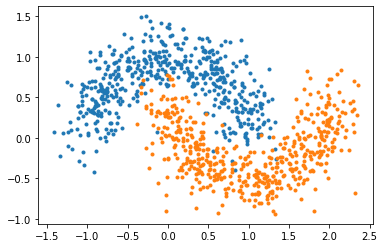

In [67]:
all_data = data_gen()

zeros_x = [all_data[i][0][0] for i in range(N) if not all_data[i][1]]
zeros_y = [all_data[i][0][1] for i in range(N) if not all_data[i][1]]

ones_x = [all_data[i][0][0] for i in range(N) if all_data[i][1]]
ones_y = [all_data[i][0][1] for i in range(N) if all_data[i][1]]

plt.plot(zeros_x, zeros_y, '.')
plt.plot(ones_x, ones_y, '.')

In [68]:
train_data = all_data[:N*8//10]
test_data = all_data[N*8//10:]
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [69]:
output1 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    nn.Linear(output1, 1)
)

In [70]:
from tqdm.notebook import tqdm, trange

epochs = 200
num_of_params = get_n_params(model)


optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

effective_ranks = []

for epoch in trange(epochs):
    row_counter = 0
    tensor = torch.zeros((len(train_loader),num_of_params))
    C_matrices = []
    for points, labels in train_loader:
        
        optimizer.zero_grad()

        x = points[:,:,0].float()
        # print(x.shape)
        labels = labels[:,None].double()

        y = model(x)
        loss = criterion(y, labels)
        
        loss.backward()
        optimizer.step()

        tensor[row_counter, :] = flatten_and_together([param.grad for param in list(model.parameters())])
        row_counter += 1
    C_matrix = tensor @ tensor.T
    C_diags = np.sqrt(np.outer(tensor.diagonal(), tensor.diagonal()))
    effective_ranks.append(effective_rank(tensor))
    C_matrices.append(C_matrix)
    

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\szilv\AppData\Local\Temp\ipykernel_16500\3778226689.py:33: RuntimeWarning: invalid value encountered in sqrt
  C_diags = np.sqrt(np.outer(tensor.diagonal(), tensor.diagonal()))


In [71]:
C_matrices[-1]

tensor([[ 1.4204e-02, -8.4476e-03, -1.2988e-02,  ..., -1.9754e-03,
          1.2720e-02, -2.1613e-03],
        [-8.4476e-03,  1.2656e-02,  1.0730e-02,  ...,  4.3998e-04,
         -1.4483e-02,  5.3749e-06],
        [-1.2988e-02,  1.0730e-02,  2.1830e-02,  ...,  1.3400e-03,
         -1.8433e-02, -1.2887e-02],
        ...,
        [-1.9754e-03,  4.3998e-04,  1.3400e-03,  ...,  1.0501e-02,
         -1.4501e-03,  1.3004e-02],
        [ 1.2720e-02, -1.4483e-02, -1.8433e-02,  ..., -1.4501e-03,
          3.7829e-02,  5.4014e-03],
        [-2.1613e-03,  5.3749e-06, -1.2887e-02,  ...,  1.3004e-02,
          5.4014e-03,  4.6960e-02]])

In [72]:
negatives = []
for C in C_matrices:
    for col_ind, col in enumerate(C):
        for row_ind, item in enumerate(col):
            if row_ind != col_ind and item < 0:
                negatives.append(item)
print("Negatives:", len(negatives))
print("Positives: ", 40**2-40-len(negatives))


Negatives: 770
Positives:  790


Text(0, 0.5, 'Effective rank')

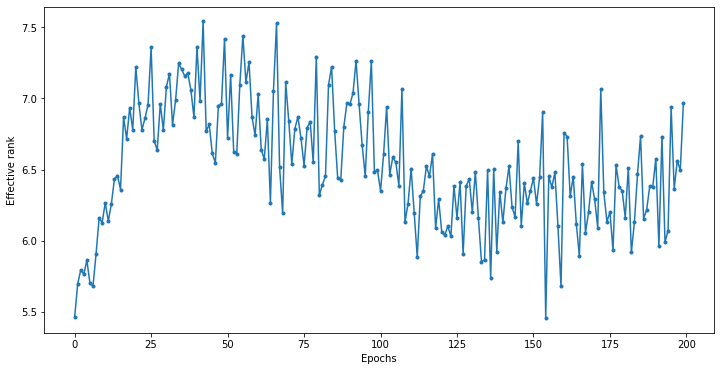

In [73]:
from matplotlib.pyplot import figure

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)

plt.plot(effective_ranks, '.-')
plt.xlabel("Epochs")
plt.ylabel("Effective rank")


In [74]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            # print(predictions2)
            # print(labels2)
            correct_test += torch.sum((predictions2 == labels2).float())
            # print(correct_test)
print(f'Test accuracy: {correct_test/len(test_data)}')


Test accuracy: 0.8899999856948853


In [37]:
tensor = torch.tensor([[-7.9811e-01,  4.2888e-01],[ 1,  0.0000e+00]])
effective_rank(tensor)

tensor(1.6498)

In [38]:
tensor = torch.tensor([1/2, 3/4])
model(tensor)

tensor([-3.8010], grad_fn=<AddBackward0>)